<a href="https://colab.research.google.com/github/YogithL/Data-Science/blob/main/YogithL_Unit2Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**UT Admissions from LASA**


**Context**

Every year, a number of students from LASA apply to UT due to its strong academic programs, reputation, and proximity to home. However, despite the high volume of LASA applicants, the number of students who actually get accepted varies given the competitive nature of UT's admissions process. This raises the question: out of the large pool of LASA applicants, how many ultimately secure a spot at UT?





**Intial Assumptions**

As a LASA student planning on applying to UT, it seems around 25 percent of students get accepted. I got this prior from using the general consensus that LASA students have about UT admissions and the idea that UT may "favor" students from our school. Historically, this number has also not been too far off from the actual addmitance rate.        



In [2]:
#Importing neccessary libraries
!pip install preliz
import preliz as pz
import numpy as np
import arviz as az
import pymc as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.6/505.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


<Axes: >

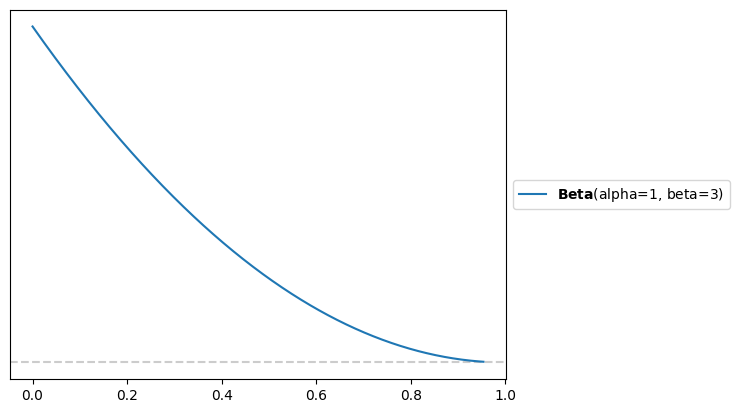

In [3]:
pz.Beta(alpha=1,beta=3).plot_pdf()

The graph above represents our prior distribution, modeled by $Beta(a=1, B=3)$. In this context, $a$ reflects that 1 out of 4 LASA students who apply to UT is likely to be addmitted, while B suggests that 3 out of 4 applicants from our school are likely to get rejected. The values below are estimates of UT's addmitance percentage from LASA using our prior; each minimize how wrong our guess will be according to loss functions.



In [12]:
UT_prior = pz.Beta(alpha=1,beta=3)

UT_prior_mode = (UT_prior.alpha - 1)/(UT_prior.alpha + UT_prior.beta - 2)

#the mean mean first, then median, and finally mode
UT_prior.mean(), UT_prior.median(), UT_prior_mode

(0.25, 0.20629947401590032, 0.0)

**Our Data**

Using Naviance we know that for last year, the class of 2024, 216 students applied and 78 got accepted ($a=78$ & $b=138$). So the likelihood of seeing this data, given that we know $UT$, the true chance of a LASA student getting into UT, is $p(y|UT)$. In other words, it's the probability of seeing 78 out of 216 students get into UT given  LASA's students' true acceptance rate.


$p(y|UT)=Binomial(n=216,k=78,UT)=\binom {n}{k}UT^{k}(1-UT)^{n-k}=\frac{216!}{(216-78)!78!}UT^{78}(1-UT)^{2}$

Let's see the distribution graphed below

<Axes: >

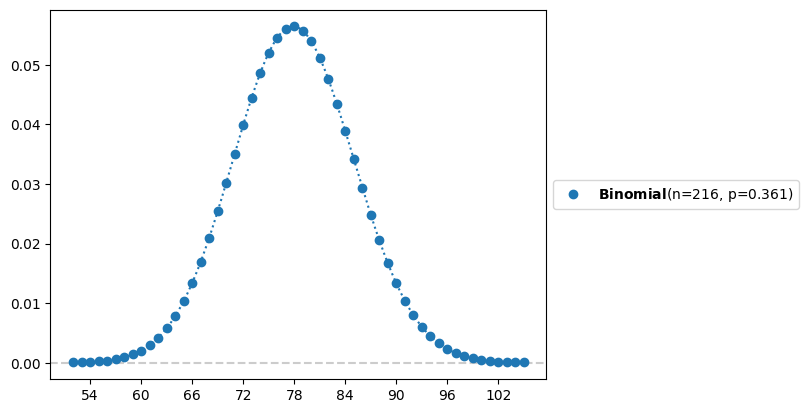

In [4]:
pz.Binomial(n = 216, p = 78/216 ).plot_pdf()

**Making our predictions**

Since we have both the prior and likelihood, we can use the posterior formula, $p(y|UT)p(UT)$, to find the true UT admittance rate for LASA students.

In [5]:
#prior information
alpha_old = 1
beta_old = 3

#likelihood info, or data from Naviance
k = 77 #Acceptances
n = 216 #Total Applications

# mathematical formula
analytic_UT = pz.Beta(alpha = alpha_old + k,beta = beta_old + n - k )

analytic_UT.mean()

0.35454545454545455

Since we learned that the entire distribution better represents our uncertainty compared to a single guess, let’s examine it before moving on to making predictions.

<Axes: >

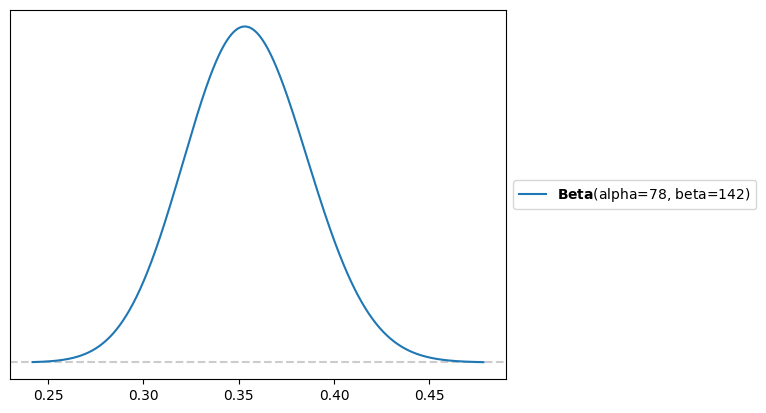

In [6]:
analytic_UT.plot_pdf()

Now that we got to take a look at the distribution and the mean, lets start making our actual predictions.

In [7]:
import pymc as pm

#the acceptances we've seen from the class of 2024
UT_acceptances = np.repeat(1, 78)

#the rejections we've seen from the class of 2024
UT_rejections = np.repeat(0, 138)

#combining the acceptances and rejections into one array
UT_data = np.concatenate( [UT_acceptances, UT_rejections] )

In [8]:
with pm.Model() as UT_model:
  #we define our prior with my intial assumptions
  UT = pm.Beta('UT' , alpha = 1. , beta = 3.)

  #we define our likelihood, which is how we process the admittances from the class of 2025
  #Think of Bernoulli as a stand in for the binomial distribution
  #It doesn't have inherent info about number of attempts, but number of attempts
  #is included in the data anyway.
  y = pm.Bernoulli('y', p = UT, observed = UT_data)

  #We sample from our posterior because we don't actually have a formula for it.
  idata_UT = pm.sample(1000)

<Axes: title={'center': 'UT'}>

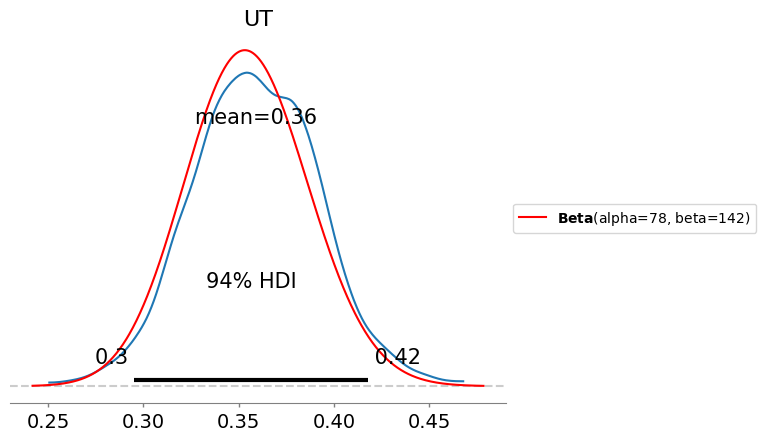

In [9]:
import arviz as az
az.plot_posterior(idata_UT) #Visualizing the 1000 samples from the pymc model of the posterior
analytic_UT.plot_pdf(color='red')

#Notice how both graphs share a similar shape

In [10]:
#The below function needs to know two things in order to make predictions:
#-the samples from the posterior; these are stored in idata_UT
#-the model that generated those samples, which we called UT_model
# The last input tells the function to store those predictions in idata_UT

pm.sample_posterior_predictive(idata_UT, model=UT_model, extend_inferencedata=True)

#stack the two MCMC chains together for a total of 2000 samples, or predictions
#Why 2000? 1000 per chain. Why 1000? Because we asked for 1000 samples when
#we specified the model.
stacked_UT = az.extract(idata_UT, group="posterior_predictive")

stacked_UT.sel(sample=0).sel(draw=0).y.to_series().values

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [14]:
x=stacked_UT.sel(sample=0).sel(draw=0).y.to_series().values

print((100*(sum(x)/216))) #The sum of all the ones (acceptances) divided by the total number of aplicants

29.166666666666668


The array above is the predictions for the next 216 applicants to UT from LASA, with a 1 corresponding to an acceptance and a 0 to a rejection. And from this array, we have a rounded acceptance rate of around 40% for the upcoming class of 2025.


**Final Thoughts**

Compared to last year's 36%, it appears only ~29% of LASA students will get admitted into UT. This makes sense when taking into consideration that our class size is larger and the class of 2024's academic record is agreed to have been better. Ultimately, our final model seems like a probable prediction for the next 216 applicants into UT given data from the class of 2024.  